# Analysis notebook for QSHE data

tauhis notebook is for loading generated histogram files and preliminary plotting/testing. For complete plotting and moments calculations, 
run analysis/data_plotting or analysis/critical_exponent instead. 


In [31]:
# Simple module imports
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from scipy.stats import norm

# Lazy imports - comment out when not in use
from constants import *
from source.utilities import *
from source.config import *
# from analysis.data_plotting import *
# from analysis.critical_exponent import *
from QSHE.testing_qshe import *
from Local.run_local_qshe import *


Mean = 0.19188512800000046, STD = 1.8406797691126024


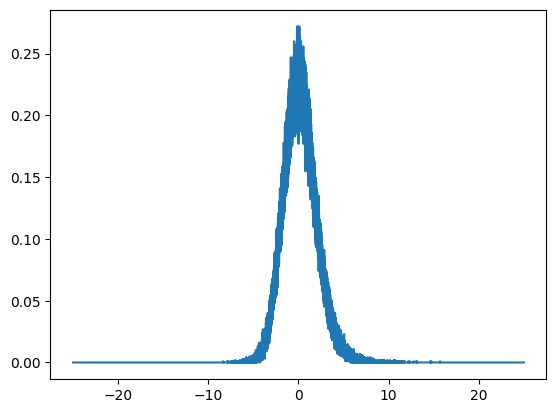

In [ ]:
# Plot z data for the old z definition
z_data = np.load(f"{local_dir}/rg_qshe_test_numerical_shaw/FP/hist/z/z_hist_RG0.npz")
z_counts = z_data["densities"]
z_bins = z_data["binedges"]
z_centers = z_data["bincenters"]
z_densities = z_data["densities"]
plt.plot(z_centers, z_densities, label="hist")
mean, std = hist_moments(z_counts, z_bins)
print(f"Mean = {mean}, STD = {std}")
# plt.legend()
# plt.show()

Loaded: Mean = 9.992007221626409e-16, STD = 1.8340653115682657
Took 1 iterations in total.
Sampled: Mean = 0.0011654680000008355, STD = 1.835207382948407


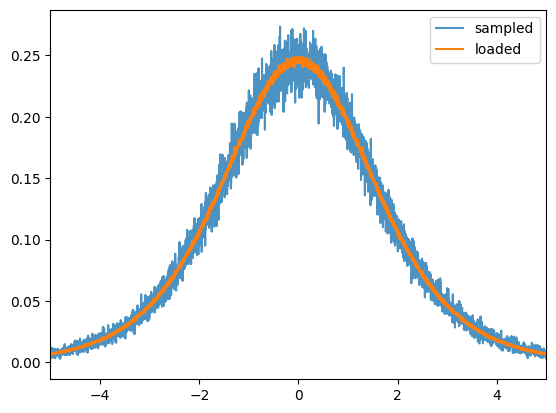

In [ ]:
# Take the fixed point distribution P(z_eff, L) from v7.41
plt.figure("7.40")
data_folder = f"{local_dir}/rg_qshe_7.40_numerical_shaw/FP"
hist2d = np.load(f"{data_folder}/hist/zf/zf_hist_RG9.npz")
config_dict = load_yaml(f"{data_folder}/updated_config.yaml")
config = build_config(config_dict)
rng = build_rng(config.seed)
n = 1000000
zbins= config.z_bins
zrange = config.z_range
tbins = config.t_bins
trange=  config.t_range
# for keys in hist2d.keys():
#     print(keys)
var2d = "z_f"
hist_dict = {"z_f": {"densities": hist2d["zfcounts"]}, "z": {"binedges": hist2d["zbins"]}, "f": {"binedges": hist2d["fbins"]}}
zmean, zstd = hist_moments(hist2d["zcounts"], hist2d["zbins"])
print(f"Loaded: Mean = {zmean}, STD = {zstd}")


zsample, fsample = conditional_2d_resampler(hist_dict, rng, n, var2d)
zsamp = build_hist(zsample, zbins, zrange)
m, s = hist_moments(zsamp["histval"], zsamp["binedges"])
print(f"Sampled: Mean = {m}, STD = {s}")
plt.plot(zsamp["bincenters"], zsamp["densities"], label="sampled", alpha=0.8)
plt.plot(hist2d["zcenters"], hist2d["zdensities"], label="loaded")
plt.xlim((-5.0, 5.0))
plt.legend()
plt.show()

dict_keys(['histval', 'densities'])


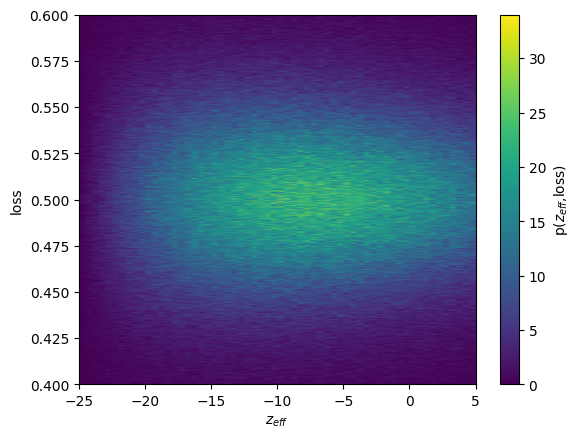

In [ ]:
d = np.load(f"{local_dir}/test_2d_numerical_shreyas/FP/hist/2d/2d_hist_RG1.npz", allow_pickle=True)
zf = d["z_f"].item()
z = d["z"].item()
f = d["f"].item()
fig, ax = plt.subplots()
zf_counts = zf["histval"]
image = ax.imshow(
    zf_counts,
    origin="lower",
    extent=(
        z["binedges"][0],
        z["binedges"][-1],
        f["binedges"][0],
        f["binedges"][-1],
    ),
    aspect="auto",
    # norm=LogNorm(
    #     vmin=max(zf_counts.min(), 1e-6),
    #     vmax=zf_counts.max(),
    # ),
)
ax.set_xlabel(r"$z_{eff}$")
ax.set_ylabel("loss")
ax.set_ylim((0.4, 0.6))
ax.set_xlim((-25.0, 5.0))
fig.colorbar(image, ax=ax, label=r"p($z_{eff}$,loss)")
plt.show()

#### Testing $\pm z_0$ shifts and computing $Cov(z, L)$ for a few RG steps

In [ ]:
# Load all histogram data from test_2d_numerical_shreyas
data_folder = f"{local_dir}/test_2d_numerical_shreyas/EXP"
shifts = [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
hists = {}
vars = ["r", "t", "tau", "f", "leak", "surv", "z", "2d"]
nsteps = 10
for shift in shifts:
    hist_folder = f"{data_folder}/hist/{shift}"
    hists.update({f"{shift}": {}})
    for step in range(nsteps):
        hists[f"{shift}"].update({f"RG{step}": {}})
        for var in vars:
            var_folder = f"{hist_folder}/{var}"
            data = np.load(f"{var_folder}/{var}_hist_RG{step}.npz", allow_pickle=True)
            if var == "2d":

                hists[f"{shift}"][f"RG{step}"].update({f"z_f": })
            else:
                hists[f"{shift}"][f"RG{step}"].update({f"{var}": data})
print(hists["-0.4"]["RG1"]["2d"]["z_f"].item().keys())


TypeError: 'KeysView' object is not subscriptable

#### Check for original unitarity constraints $<|t|^2 + |r|^2 +|tau|^2 + |f|^2>$ = 1 and $<s> + <L> = 1$

In [46]:
for shift in shifts:
    for step in range(nsteps):
        tdata = hists[f"{shift}"][f"RG{step}"]["t"]
        rdata = hists[f"{shift}"][f"RG{step}"]["r"]
        taudata = hists[f"{shift}"][f"RG{step}"]["tau"]
        fdata = hists[f"{shift}"][f"RG{step}"]["f"]
        survdata = hists[f"{shift}"][f"RG{step}"]["surv"]
        leakdata =  hists[f"{shift}"][f"RG{step}"]["leak"]
        twoddata = hists[f"{shift}"][f"RG{step}"]["2d"]
        tmean, tstd = hist_moments(tdata["densities"], tdata["binedges"])
        rmean, rstd = hist_moments(rdata["densities"], rdata["binedges"])
        taumean, taustd = hist_moments(taudata["densities"], taudata["binedges"])
        fmean, fstd = hist_moments(fdata["densities"], fdata["binedges"])
        survmean, survstd = hist_moments(survdata["densities"], survdata["binedges"])
        leakmean, leakstd = hist_moments(leakdata["densities"], leakdata["binedges"])
        meandiff = np.abs(tmean**2 + rmean**2 + taumean**2 + fmean**2 - 1.0)
        slsum = survmean + leakmean
        print(f"RG step {step} of shift {shift}")
        try:
            assert meandiff <= 1e-2
            print(meandiff)
            assert np.abs(slsum - 1.0) <= 1e-2
            print(slsum)
        except AssertionError:
            print("Assertion failed!")
            print(meandiff)
            print(slsum)
        print("-"*20)

RG step 0 of shift -0.4
Assertion failed!
0.1623894913409195
1.0
--------------------
RG step 1 of shift -0.4
Assertion failed!
0.16239856975667133
1.0
--------------------
RG step 2 of shift -0.4
Assertion failed!
0.1624386883871367
1.0000000000000002
--------------------
RG step 3 of shift -0.4
Assertion failed!
0.1623152831099529
1.0
--------------------
RG step 4 of shift -0.4
Assertion failed!
0.1624098117615127
1.0000000000000002
--------------------
RG step 5 of shift -0.4
Assertion failed!
0.1623753912748962
1.0
--------------------
RG step 6 of shift -0.4
Assertion failed!
0.16228906787258324
1.0
--------------------
RG step 7 of shift -0.4
Assertion failed!
0.16232950799481471
1.0
--------------------
RG step 8 of shift -0.4
Assertion failed!
0.16227610857866082
1.0000000000000004
--------------------
RG step 9 of shift -0.4
Assertion failed!
0.16229717156557943
1.0
--------------------
RG step 0 of shift -0.3
Assertion failed!
0.16235940778056235
1.0
--------------------
RG 

In [ ]:
stats_folder = f"{data_folder}/stats"
zl_moments= {}
for shift in shifts:
    zl_moments.update({f"{shift}": {}})
    for step in range(nsteps):
            zdata = hists[f"{shift}"][f"RG{step}"]["z"]
            ldata = hists[f"{shift}"][f"RG{step}"]["leak"]
            zmean, zstd = hist_moments(zdata["histval"], zdata["binedges"])
            lmean, lstd = hist_moments(ldata["histval"], ldata["binedges"])

            zl_moments[f"{shift}"].update()


[0 0 0 ... 0 0 0]
